# 비지도 학습
## 10-2강 깊은 k 평균 알고리즘 (오토인코더 + k 평균 알고리즘)

Maziar Moradi Fard, Thibaut Thonet, Eric Gaussier, Deep k-Means: Jointly clustering with k-Means and learning representations, Pattern Recognition Letters 2020

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [ ]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/deeplearningbrov2/pytorch

/content/gdrive/My Drive/deeplearningbrov2/pytorch


### 데이터 불러오기

In [ ]:
batch_size = 128
num_clusters = 10
latent_size = 10

In [ ]:
trainset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST('./data/', download=True, train=False, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

### 모델 정의

In [ ]:
class Flatten(torch.nn.Module): 
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1) 
    
class Deflatten(nn.Module): 
    def __init__(self, k):
        super(Deflatten, self).__init__()
        self.k = k
        
    def forward(self, x):
        s = x.size()
        feature_size = int((s[1]//self.k)**.5)       
        return x.view(s[0],self.k,feature_size,feature_size)

class Kmeans(nn.Module): 
    def __init__(self, num_clusters, latent_size):
        super(Kmeans, self).__init__()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.num_clusters = num_clusters
        self.centroids = nn.Parameter(torch.rand((self.num_clusters, latent_size)).to(device))
    
    def argminl2distance(self, a, b):    
        return torch.argmin(torch.sum((a-b)**2,dim=1),dim=0)

    def forward(self, x):
        y_assign = []
        for m in range(x.size(0)):
            h = x[m].expand(self.num_clusters,-1)
            assign = self.argminl2distance(h, self.centroids)
            y_assign.append(assign.item())
        
        return y_assign, self.centroids[y_assign]

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        
        k = 16
        self.encoder = nn.Sequential(
                        nn.Conv2d(1, k, 3, stride=2), 
                        nn.ReLU(), 
                        nn.Conv2d(k, 2*k, 3, stride=2),
                        nn.ReLU(), 
                        nn.Conv2d(2*k, 4*k, 3, stride=1),
                        nn.ReLU(),
                        Flatten(),
                        nn.Linear(1024, latent_size), 
                        nn.ReLU()
        )

    def forward(self, x):       
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        
        k = 16
        self.decoder = nn.Sequential(
                        nn.Linear(latent_size, 1024),
                        nn.ReLU(),
                        Deflatten(4*k),
                        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), # (입력 채널 수, 출력 채널 수, 필터 크기, stride)
                        nn.ReLU(),
                        nn.ConvTranspose2d(2*k, k, 3, stride=2),
                        nn.ReLU(),
                        nn.ConvTranspose2d(k, 1, 3, stride=2,output_padding=1),
                        nn.Sigmoid()
        )
    
    def forward(self, x):       
        return self.decoder(x)

### 클러스터링 정확도 함수 정의

In [ ]:
def cluster_acc(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    
    return sum([w[i, j] for i, j in zip(ind[0], ind[1])]) * 1.0 / y_pred.size
         
def evaluation(testloader, encoder, kmeans, device):
    predictions = []
    actual = []

    with torch.no_grad():
        encoder.eval()
        for images, labels in testloader: 
            inputs = images.to(device)
            labels = labels.to(device)
            latent_var = encoder(inputs)
            y_pred, _ = kmeans(latent_var)
            
            predictions += y_pred
            actual += labels.cpu().tolist()
    encoder.train() 
    return cluster_acc(actual, predictions)

### 손실함수 및 최적화 방법 정의

In [ ]:
encoder = Encoder(latent_size).to(device)
decoder = Decoder(latent_size).to(device)
kmeans = Kmeans(num_clusters, latent_size).to(device)

In [ ]:
# Loss and optimizer
criterion1 = torch.nn.MSELoss()
criterion2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + 
                              list(decoder.parameters()) +
                              list(kmeans.parameters()), lr=1e-3)

### 학습하기

In [ ]:
# Training
T1 = 50
T2 = 200
lam = 1e-3
ls = 0.05
for ep in range(300):
    if (ep > T1) and (ep < T2):
        alpha = lam*(ep - T1)/(T2 - T1) # 1/100, 2/100, .., 99/100
    elif ep >= T2:    
        alpha = lam
    else:
        alpha = lam/(T2 - T1)
        
    running_loss = 0.0
    for images, _ in trainloader:
        inputs = images.to(device)
        optimizer.zero_grad()
        latent_var = encoder(inputs)
        _, centroids = kmeans(latent_var.detach())
        outputs = decoder(latent_var)
        
        l_rec = criterion1(inputs, outputs) 
        l_clt = criterion2(latent_var, centroids) 
        loss = l_rec + alpha*l_clt
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
  
    avg_loss = running_loss / len(trainloader)        
    
    if ep % 10 == 0:               
        testacc = evaluation(testloader, encoder, kmeans, device)
        print('[%d] Train loss: %.4f, Test Accuracy: %.3f' %(ep, avg_loss, testacc))  
        
    if avg_loss < ls:
        ls = avg_loss
        torch.save(encoder.state_dict(),'./models/dkm_en.pth')
        torch.save(decoder.state_dict(),'./models/dkm_de.pth')
        torch.save(kmeans.state_dict(),'./models/dkm_clt.pth')

[0] Train loss: 0.0834, Test Accuracy: 0.114
[10] Train loss: 0.0238, Test Accuracy: 0.114
[20] Train loss: 0.0215, Test Accuracy: 0.263
[30] Train loss: 0.0206, Test Accuracy: 0.322
[40] Train loss: 0.0201, Test Accuracy: 0.432
[50] Train loss: 0.0197, Test Accuracy: 0.497
[60] Train loss: 0.0195, Test Accuracy: 0.592
[70] Train loss: 0.0193, Test Accuracy: 0.672
[80] Train loss: 0.0191, Test Accuracy: 0.749
[90] Train loss: 0.0190, Test Accuracy: 0.768
[100] Train loss: 0.0189, Test Accuracy: 0.824
[110] Train loss: 0.0188, Test Accuracy: 0.844
[120] Train loss: 0.0187, Test Accuracy: 0.845
[130] Train loss: 0.0186, Test Accuracy: 0.847
[140] Train loss: 0.0185, Test Accuracy: 0.847
[150] Train loss: 0.0185, Test Accuracy: 0.847
[160] Train loss: 0.0184, Test Accuracy: 0.851
[170] Train loss: 0.0183, Test Accuracy: 0.852
[180] Train loss: 0.0183, Test Accuracy: 0.856
[190] Train loss: 0.0183, Test Accuracy: 0.856
[200] Train loss: 0.0182, Test Accuracy: 0.857
[210] Train loss: 0.0182

### 시각화 예시

#### MNIST 실제제 이미지와 생성이미지 비교

In [ ]:
encoder.load_state_dict(torch.load('./models/dkm_en.pth'))
decoder.load_state_dict(torch.load('./models/dkm_de.pth'))
kmeans.load_state_dict(torch.load('./models/dkm_clt.pth'))


<All keys matched successfully>

Input images


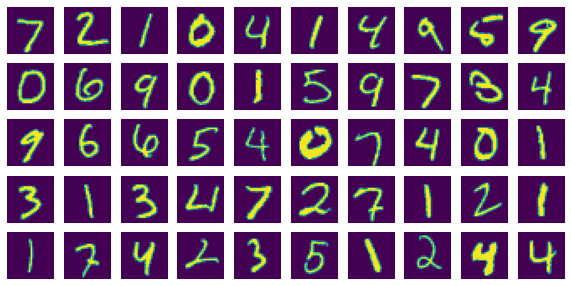

Reconstruction images


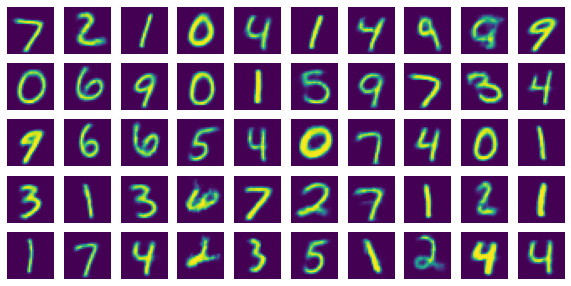

In [ ]:
with torch.no_grad():
    encoder.eval()
    for images, _ in testloader: 
        inputs = images.to(device)
        latent_var = encoder(inputs)
        outputs = decoder(latent_var)
        
        input_samples = inputs.permute(0,2,3,1).cpu().numpy()
        reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy()
        break

columns = 10
rows = 5
print("Input images")  
fig=plt.figure(figsize=(columns, rows))
for i in range(1, columns*rows+1):
    img = input_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.axis('off')
plt.show()

print("Reconstruction images") 
fig=plt.figure(figsize=(columns, rows))
for i in range(1, columns*rows+1):
    img = reconstructed_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.axis('off')  
plt.show()

In [ ]:
predictions = []
actual = []
latent_features = []
with torch.no_grad():
    for images, labels in testloader: 
        inputs = images.to(device)
        labels = labels.to(device)
        latent_var = encoder(inputs)
        y_pred, _ = kmeans(latent_var)
        
        predictions += y_pred
        latent_features += latent_var.cpu().tolist()
        actual += labels.cpu().tolist()
            
print(cluster_acc(actual, predictions))

0.8641


#### t-SNE(10.2절)를 이용하여 나타낸 비지도 학습 모델이 예측한 결과

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(latent_features)))
actual = np.array(actual)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


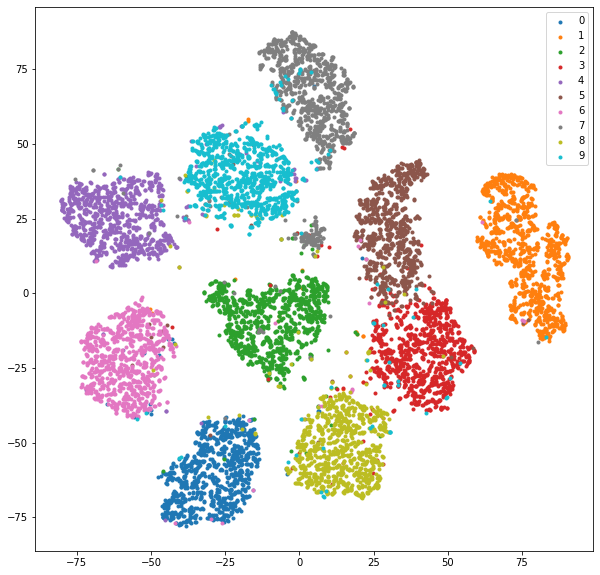

In [ ]:
plt.figure(figsize=(10, 10))
mnist = range(10)
for i, label in zip(range(10), mnist):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=str(label))
plt.legend()
plt.show()